# Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Optional: prettier tables
pd.set_option("display.max_columns", 50)

In [2]:
!pip install scikit-learn

# Diabetes Prediction

# Load Dataset

In [3]:
DATA_PATH = Path("diabetes_prediction_dataset.csv")
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# Preprocess
# Keep numeric columns only (GMM expects numeric features)
X = df.select_dtypes(include=[np.number]).copy()

# Drop constant columns (if any)
X = X.loc[:, X.nunique(dropna=False) > 1]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

Xs = pipe.fit_transform(X)
Xs.shape

(100000, 7)

# Principal Component Analysis (PCA)

In [5]:
# PCA
# Use up to 5 PCs for GMM modeling (helps covariance estimation on big tabular data)
pca_dim = min(5, Xs.shape[1])
pca_model = PCA(n_components=pca_dim, random_state=42)
Xp = pca_model.fit_transform(Xs)

# We'll plot in 2D and 3D using the first 2 or 3 PCs, respectively
print("Explained variance (first 5 PCs or fewer):", pca_model.explained_variance_ratio_)

Explained variance (first 5 PCs or fewer): [0.30133365 0.16985723 0.13471366 0.12131828 0.11901963]


In [6]:
# JUPYTER CELL 5 — Model selection with BIC on a sample for speed
rng = np.random.default_rng(42)
n = Xp.shape[0]

# Subsample to speed up BIC search; increase if your machine is strong
sample_n = min(5000, n)
idx = rng.choice(n, size=sample_n, replace=False)
Xp_s = Xp[idx]

k_list = [2, 3, 4, 5]   # try more if you like
bics = []
models = []

for k in k_list:
    gm = GaussianMixture(
        n_components=k,
        covariance_type="diag",  # 'diag' is fast & good for many tabular problems
        reg_covar=1e-6,
        max_iter=200,
        n_init=2,
        random_state=42
    )
    gm.fit(Xp_s)
    bics.append(gm.bic(Xp_s))
    models.append(gm)

bic_table = pd.DataFrame({"k": k_list, "BIC": bics}).sort_values("BIC")
bic_table


C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1538

,k,BIC
3,5,50245.266785
2,4,53549.117511
1,3,54975.233469
0,2,60826.805467


In [7]:
# JUPYTER CELL 6 — Fit the chosen model & label sample
best_idx = int(np.argmin(bics))
best_k = int(k_list[best_idx])
best_gmm = models[best_idx]

labels_s = best_gmm.predict(Xp_s)            # hard labels
proba_s  = best_gmm.predict_proba(Xp_s)      # soft memberships (responsibilities)

print("Chosen k (by BIC):", best_k)
pd.Series(labels_s).value_counts().sort_index()

Chosen k (by BIC): 5


0     957
1     921
2     639
3    2199
4     284
Name: count, dtype: int64

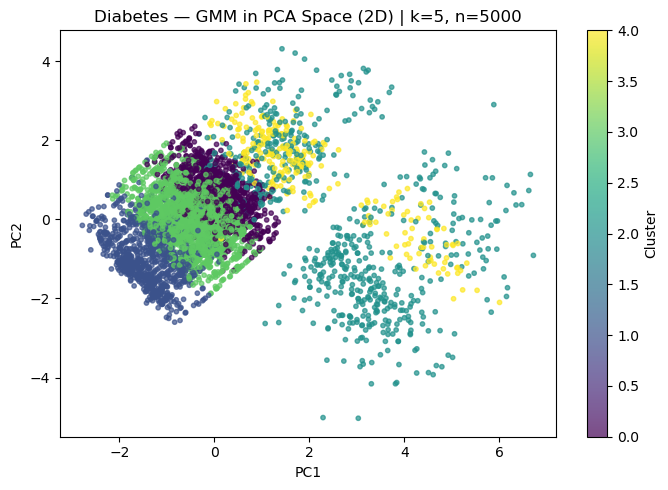

In [15]:
# JUPYTER CELL 7 — 2D PCA plot with colour palette legend
plt.figure(figsize=(7,5))
sc = plt.scatter(Xp_s[:, 0], Xp_s[:, 1],
                 s=10, alpha=0.7, c=labels_s, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Diabetes — GMM in PCA Space (2D) | k={best_k}, n={len(Xp_s)}")

# Add colour bar legend
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.tight_layout()
# If you want to save: plt.savefig("diabetes_gmm_pca_2d.png", dpi=150)
plt.show()

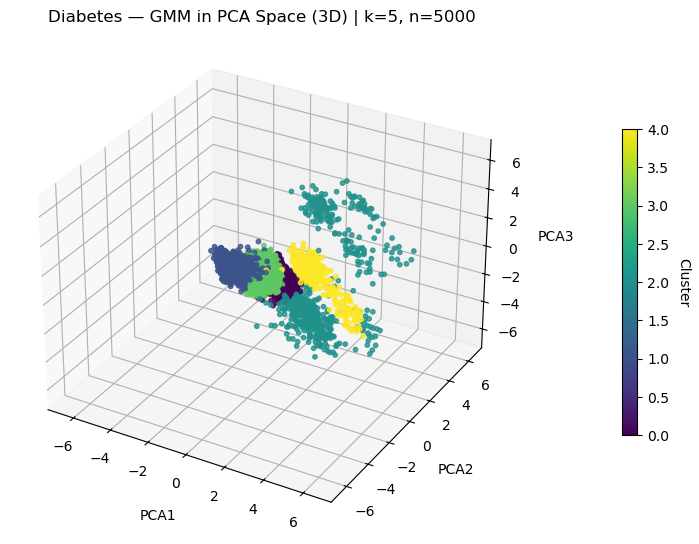

In [24]:
# JUPYTER CELL 8 — 3D PCA plot (with full PC3 view + color legend)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.cm import ScalarMappable

if pca_dim >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter with explicit colormap
    cmap = plt.cm.viridis
    sc = ax.scatter(Xp_s[:, 0], Xp_s[:, 1], Xp_s[:, 2],
                    s=10, alpha=0.8, c=labels_s, cmap=cmap)

    ax.set_xlabel("PCA1", labelpad=10)
    ax.set_ylabel("PCA2", labelpad=10)
    ax.set_zlabel("PCA3", labelpad=10)
    ax.set_title(f"Diabetes — GMM in PCA Space (3D) | k={best_k}, n={len(Xp_s)}")

    # ---- make sure full axis range is visible ----
    # set equal-ish limits based on the whole dataset
    lim = np.max(np.abs(Xp_s[:, :3])) * 1.1
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)

    # ---- add colorbar legend on right ----
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array(labels_s)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.15, shrink=0.6)
    cbar.set_label("Cluster", rotation=270, labelpad=15)

    # give more breathing room so labels don’t clip
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9)
    plt.show()
else:
    print("Not enough PCs for 3D (need >=3).")


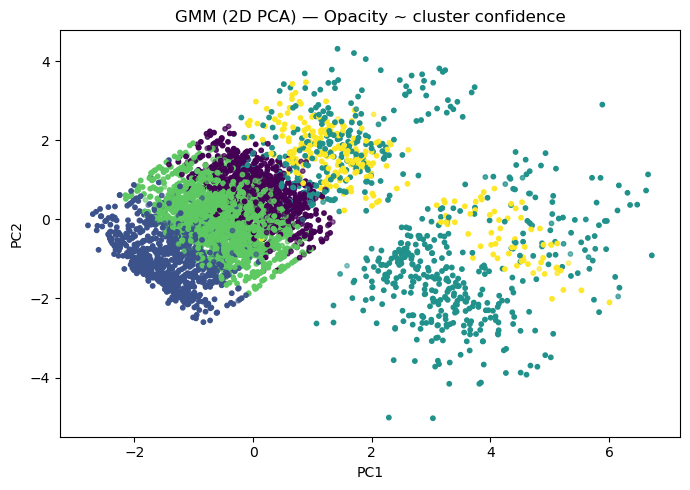

In [10]:
# JUPYTER CELL 9 — Optional: opacity by confidence (max responsibility)
confidence = proba_s.max(axis=1)  # in [0,1]; 1 = very confident
plt.figure(figsize=(7,5))
plt.scatter(Xp_s[:, 0], Xp_s[:, 1], s=10, alpha=confidence, c=labels_s)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("GMM (2D PCA) — Opacity ~ cluster confidence")
plt.tight_layout()
plt.show()

In [11]:
# JUPYTER CELL 10 — Full-dataset labeling
labels_full = best_gmm.predict(Xp)       # hard labels on full data
proba_full  = best_gmm.predict_proba(Xp) # soft memberships on full data

# Quick sizes
pd.Series(labels_full).value_counts().sort_index()


0    20038
1    18273
2    11891
3    43709
4     6089
Name: count, dtype: int64

In [12]:
# JUPYTER CELL 11 — Cluster profiles on original feature scale
# Undo scaling on cluster means: average in original (imputed) space
X_imputed = pipe.named_steps["imputer"].transform(X)
X_orig = pd.DataFrame(X_imputed, columns=X.columns, index=df.index)

prof = X_orig.copy()
prof["cluster"] = labels_full
cluster_means = prof.groupby("cluster").mean().round(3)
cluster_means.head(10)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
cluster,,,,,,,
0,54.001,0.000,0.000,32.342,5.257,137.644,0.000
1,15.463,0.000,0.000,18.829,5.455,129.928,0.000
2,59.734,0.117,0.332,34.213,6.293,170.605,0.593
3,39.845,0.000,0.000,26.379,5.441,131.556,0.000
4,61.108,1.000,0.000,29.584,5.764,146.931,0.236


# World Bank Dataset

# Load Dataset

In [2]:
DATA_PATH = Path("world_bank_dataset.csv")
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(200, 8)


,Country,Year,GDP (USD),Population,Life Expectancy,Unemployment Rate (%),CO2 Emissions (metric tons per capita),Access to Electricity (%)
0,Brazil,2010,1.493220e+12,829020000.0,66.7,3.81,10.79,76.76
1,Japan,2011,1.756270e+13,897010000.0,61.4,17.98,15.67,67.86
2,India,2012,1.642688e+13,669850000.0,69.1,16.02,2.08,81.08
3,Mexico,2013,1.189001e+13,113800000.0,80.1,6.26,19.13,53.46
4,India,2014,2.673020e+12,29710000.0,62.7,3.10,15.66,82.17


In [3]:
# Preprocess
# Keep numeric columns only (GMM expects numeric features)
X = df.select_dtypes(include=[np.number]).copy()

# Drop constant columns (if any)
X = X.loc[:, X.nunique(dropna=False) > 1]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

Xs = pipe.fit_transform(X)
Xs.shape

(200, 7)

# Principal Component Analysis (PCA)

In [4]:
# PCA
# Use up to 5 PCs for GMM modeling (helps covariance estimation on big tabular data)
pca_dim = min(5, Xs.shape[1])
pca_model = PCA(n_components=pca_dim, random_state=42)
Xp = pca_model.fit_transform(Xs)

# We'll plot in 2D and 3D using the first 2 or 3 PCs, respectively
print("Explained variance (first 5 PCs or fewer):", pca_model.explained_variance_ratio_)

Explained variance (first 5 PCs or fewer): [0.17119597 0.16575291 0.16008311 0.14023969 0.13103084]


In [5]:
# JUPYTER CELL 5 — Model selection with BIC on a sample for speed
rng = np.random.default_rng(42)
n = Xp.shape[0]

# Subsample to speed up BIC search; increase if your machine is strong
sample_n = min(5000, n)
idx = rng.choice(n, size=sample_n, replace=False)
Xp_s = Xp[idx]

k_list = [2, 3, 4, 5]   # try more if you like
bics = []
models = []

for k in k_list:
    gm = GaussianMixture(
        n_components=k,
        covariance_type="diag",  # 'diag' is fast & good for many tabular problems
        reg_covar=1e-6,
        max_iter=200,
        n_init=2,
        random_state=42
    )
    gm.fit(Xp_s)
    bics.append(gm.bic(Xp_s))
    models.append(gm)

bic_table = pd.DataFrame({"k": k_list, "BIC": bics}).sort_values("BIC")
bic_table

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1538

,k,BIC
0,2,3008.525706
1,3,3056.188891
2,4,3100.466946
3,5,3137.819155


In [6]:
# JUPYTER CELL 6 — Fit the chosen model & label sample
best_idx = int(np.argmin(bics))
best_k = int(k_list[best_idx])
best_gmm = models[best_idx]

labels_s = best_gmm.predict(Xp_s)            # hard labels
proba_s  = best_gmm.predict_proba(Xp_s)      # soft memberships (responsibilities)

print("Chosen k (by BIC):", best_k)
pd.Series(labels_s).value_counts().sort_index()

Chosen k (by BIC): 2


0     80
1    120
Name: count, dtype: int64

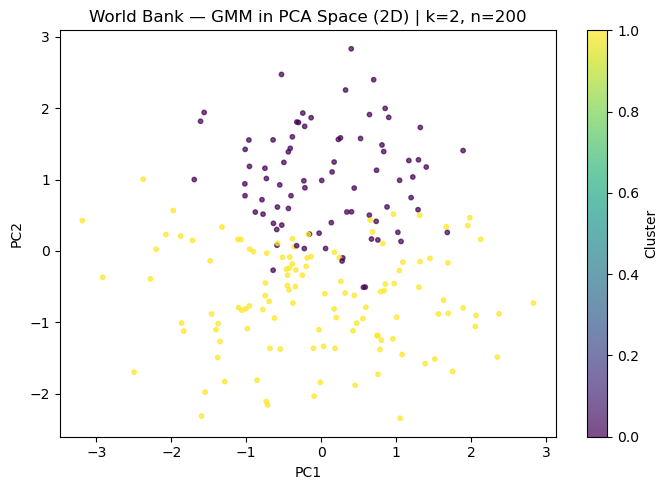

In [8]:
# JUPYTER CELL 7 — 2D PCA plot with colour palette legend
plt.figure(figsize=(7,5))
sc = plt.scatter(Xp_s[:, 0], Xp_s[:, 1],
                 s=10, alpha=0.7, c=labels_s, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"World Bank — GMM in PCA Space (2D) | k={best_k}, n={len(Xp_s)}")

# Add colour bar legend
cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.tight_layout()
# If you want to save: plt.savefig("diabetes_gmm_pca_2d.png", dpi=150)
plt.show()

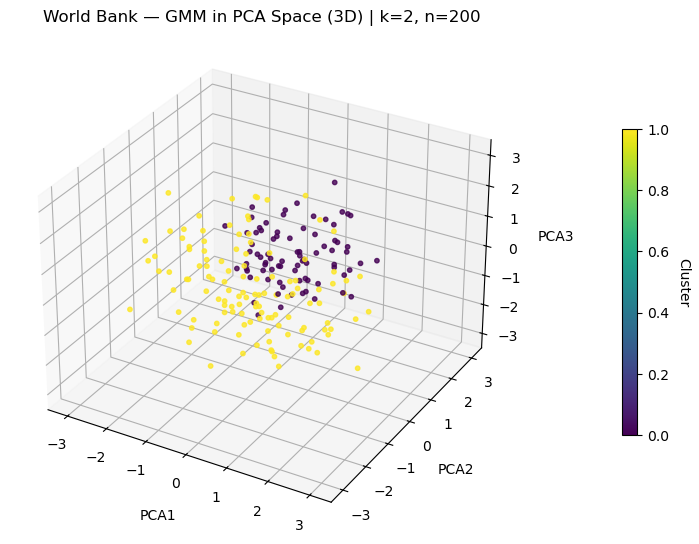

In [9]:
#JUPYTER CELL 8 — 3D PCA plot (with full PC3 view + color legend)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.cm import ScalarMappable

if pca_dim >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter with explicit colormap
    cmap = plt.cm.viridis
    sc = ax.scatter(Xp_s[:, 0], Xp_s[:, 1], Xp_s[:, 2],
                    s=10, alpha=0.8, c=labels_s, cmap=cmap)

    ax.set_xlabel("PCA1", labelpad=10)
    ax.set_ylabel("PCA2", labelpad=10)
    ax.set_zlabel("PCA3", labelpad=10)
    ax.set_title(f"World Bank — GMM in PCA Space (3D) | k={best_k}, n={len(Xp_s)}")

    # ---- make sure full axis range is visible ----
    # set equal-ish limits based on the whole dataset
    lim = np.max(np.abs(Xp_s[:, :3])) * 1.1
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)

    # ---- add colorbar legend on right ----
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array(labels_s)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.15, shrink=0.6)
    cbar.set_label("Cluster", rotation=270, labelpad=15)

    # give more breathing room so labels don’t clip
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9)
    plt.show()
else:
    print("Not enough PCs for 3D (need >=3).")

# Experimental Analysis
# Diabetes Prediction Dataset

In [9]:
from time import perf_counter
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [10]:
# JUPYTER CELL 2 — Load & preprocess
DATA_PATH = Path("diabetes_prediction_dataset.csv")  # change path if needed
df = pd.read_csv(DATA_PATH)

# numeric-only (GMM needs numeric)
X = df.select_dtypes(include=[np.number]).copy()
# drop constants if any
X = X.loc[:, X.nunique(dropna=False) > 1]

# impute + scale
pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
Xs = pre.fit_transform(X)

print("Shape after preprocessing:", Xs.shape)

Shape after preprocessing: (100000, 7)


In [11]:
# JUPYTER CELL 3 — PCA
# Use a small PCA subspace for modeling; you can tune this
PCA_DIM = min(5, Xs.shape[1])
pca = PCA(n_components=PCA_DIM, random_state=42)
Xp = pca.fit_transform(Xs)

print("Explained variance ratio (first PCs):", pca.explained_variance_ratio_)

Explained variance ratio (first PCs): [0.30133365 0.16985723 0.13471366 0.12131828 0.11901963]


In [12]:
# JUPYTER CELL 4 — Subsample for speed
rng = np.random.default_rng(42)
N = Xp.shape[0]
SAMPLE_N = min(5000, N)  # bump to 10k+ if your machine is strong
idx = rng.choice(N, size=SAMPLE_N, replace=False)
Xp_s = Xp[idx]

In [13]:
# JUPYTER CELL 5 — Ablation runner
def run_gmm_ablation(
    X,
    k_list=(2,3,4,5,6),
    cov_types=("full","tied","diag","spherical"),
    max_iter=200,
    n_init=2,
    reg_covar=1e-6,
    random_state=42,
    sil_sample=2000
):
    rows = []
    for k in k_list:
        for cov in cov_types:
            t0 = perf_counter()
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=cov,
                max_iter=max_iter,
                n_init=n_init,
                reg_covar=reg_covar,
                random_state=random_state,
            ).fit(X)
            fit_time = perf_counter() - t0

            labels = gmm.predict(X)
            # metrics
            ss = silhouette_score(X, labels,
                                  sample_size=min(sil_sample, len(X)),
                                  random_state=random_state)
            ch = calinski_harabasz_score(X, labels)
            db = davies_bouldin_score(X, labels)
            aic = gmm.aic(X)
            bic = gmm.bic(X)

            rows.append({
                "n_components": k,
                "covariance_type": cov,
                "Silhouette": ss,
                "Calinski-Harabasz": ch,
                "Davies-Bouldin": db,
                "AIC": aic,
                "BIC": bic,
                "fit_time_sec": fit_time
            })
    return pd.DataFrame(rows)

In [15]:
# JUPYTER CELL 6 — Execute ablation
ablation = run_gmm_ablation(
    Xp_s,
    k_list=(2,3,4,5),
    cov_types=("full","tied","diag","spherical"),
    max_iter=200,
    n_init=2,
    reg_covar=1e-6,
)

# show results
pd.set_option("display.max_rows", 200)
ablation.sort_values(["covariance_type","n_components"]).reset_index(drop=True)

k_list   = (2,3,4,5)
cov_list = ("full","tied","diag","spherical")

expected = pd.MultiIndex.from_product([k_list, cov_list],
                                      names=["n_components","covariance_type"])
got = (ablation
       .set_index(["n_components","covariance_type"])
       .sort_index())

# Reindex to see any missing combos (they’ll appear as NaN if absent)
grid_check = got.reindex(expected)
grid_check[["Silhouette","Calinski-Harabasz","Davies-Bouldin","AIC","BIC"]]

Silhouette  Calinski-Harabasz  Davies-Bouldin  \
n_components covariance_type                                                  
2            full               0.503241        1661.348351        1.565676   
             tied               0.515629        1282.462707        1.487119   
             diag               0.285981         429.551745        3.227321   
             spherical          0.483633        1539.234780        1.665787   
3            full               0.513461        1502.554174        1.384635   
             tied               0.204940        1445.196329        1.414941   
             diag               0.183371        1006.952367        1.751244   
             spherical          0.222556        1216.782386        1.581558   
4            full               0.495937        1523.706112        0.906981   
             tied               0.223922        1460.072223        1.326000   
             diag               0.208613        1010.163186        1.541433   
             spherical          0.210074        1014.046374        1.542039   
5            full               0.253834        1786.075449        1.121387   
             tied               0.252941        1789.108149        1.120422   
             diag               0.136323        1019.117557        1.748182   
             spherical          0.239367        1154.382511        1.309782   

                                       AIC           BIC  
n_components covariance_type                              
2            full              2722.762972   2989.967892  
             tied             66920.625243  67090.072266  
             diag             60689.944410  60826.805467  
             spherical        65420.724863  65505.448375  
3            full              1816.726895   2220.792873  
             tied             70648.545921  70857.096103  
             diag             54766.683287  54975.233469  
             spherical        62730.181728  62860.525591  
4            full             -2548.319222  -2007.392187  
             tied             55513.501815  55761.155157  
             diag             53268.878204  53549.117511  
             spherical        60389.078716  60565.042932  
5            full             -7988.221937  -7310.433846  
             tied             50727.919567  51014.676068  
             diag             49893.338353  50245.266785  
             spherical        59044.609755  59266.194324

In [18]:
# JUPYTER CELL 7 — Fit best & cluster sizes
best_row = ablation.iloc[0]
BEST_K = int(best_row["n_components"])
BEST_COV = best_row["covariance_type"]
print("Chosen by BIC -> K:", BEST_K, "cov:", BEST_COV)

best_gmm = GaussianMixture(
    n_components=BEST_K,
    covariance_type=BEST_COV,
    max_iter=300,
    n_init=3,
    reg_covar=1e-6,
    random_state=42,
).fit(Xp_s)

labels_s = best_gmm.predict(Xp_s)
pd.Series(labels_s).value_counts().sort_index()

Chosen by BIC -> K: 2 cov: full


0    4181
1     819
Name: count, dtype: int64

<Figure size 700x500 with 0 Axes>

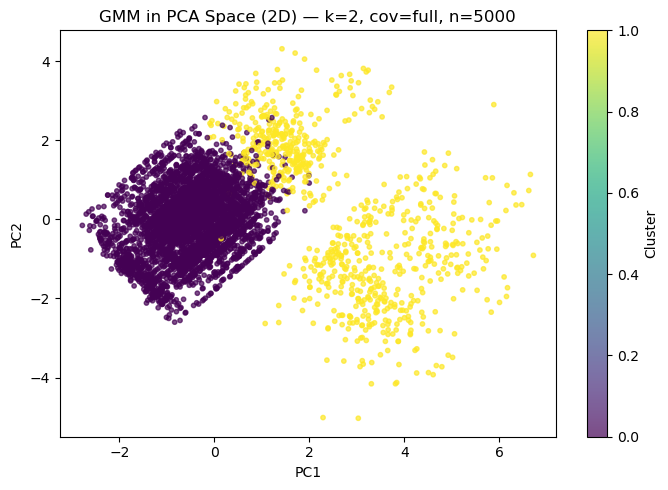

In [19]:
# JUPYTER CELL 8 — 2D PCA plot (with legend)
plt.figure(figsize=(7,5))
sc = plt.scatter(Xp_s[:,0], Xp_s[:,1], s=10, alpha=0.7, c=labels_s, cmap="viridis")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"GMM in PCA Space (2D) — k={BEST_K}, cov={BEST_COV}, n={len(Xp_s)}")
cbar = plt.colorbar(sc); cbar.set_label("Cluster")
plt.tight_layout()
plt.show()

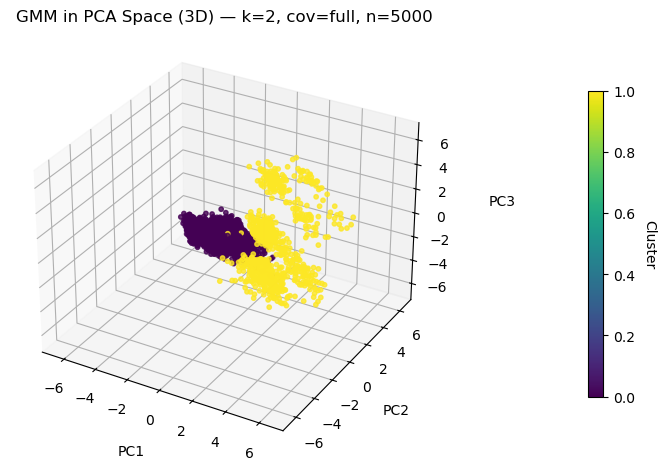

In [20]:
# JUPYTER CELL 9 — 3D PCA plot (spaced legend)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.cm import ScalarMappable

if Xp_s.shape[1] >= 3:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    cmap = plt.cm.viridis
    sc = ax.scatter(Xp_s[:,0], Xp_s[:,1], Xp_s[:,2], s=10, alpha=0.8, c=labels_s, cmap=cmap)

    ax.set_xlabel("PC1", labelpad=10)
    ax.set_ylabel("PC2", labelpad=10)
    ax.set_zlabel("PC3", labelpad=18)
    ax.set_title(f"GMM in PCA Space (3D) — k={BEST_K}, cov={BEST_COV}, n={len(Xp_s)}")

    lim = np.max(np.abs(Xp_s[:,:3])) * 1.1
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(-lim, lim)

    mappable = ScalarMappable(cmap=cmap); mappable.set_array(labels_s)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.22, shrink=0.6)
    cbar.set_label("Cluster", rotation=270, labelpad=15)

    plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.9)
    plt.show()
else:
    print("Need >=3 PCs for 3D plot.")

In [21]:
# JUPYTER CELL 10 — Full-dataset labels for profiles
best_full = GaussianMixture(
    n_components=BEST_K,
    covariance_type=BEST_COV,
    max_iter=300,
    n_init=3,
    reg_covar=1e-6,
    random_state=42,
).fit(Xp)

labels_full = best_full.predict(Xp)
pd.Series(labels_full).value_counts().sort_index()

0    16032
1    83968
Name: count, dtype: int64

In [22]:
# JUPYTER CELL 11 — Cluster mean profiles on original feature scale
X_imp = pre.named_steps["imputer"].transform(X)
X_orig = pd.DataFrame(X_imp, columns=X.columns, index=df.index)

prof = X_orig.copy()
prof["cluster"] = labels_full
cluster_means = prof.groupby("cluster").mean().round(3)
cluster_means

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
cluster,,,,,,,
0,61.747,0.467,0.246,30.896,6.210,165.369,0.53
1,38.094,0.000,0.000,26.638,5.397,132.844,0.00


In [23]:
# Show all rows if you want to inspect
pd.set_option("display.max_rows", 200)

# Sanity check: you should see all (K, covariance) combos
(ablation
 .sort_values(["covariance_type","n_components"])
 .reset_index(drop=True)
 .head(20))

,n_components,covariance_type,Silhouette,Calinski-Harabasz,Davies-Bouldin,AIC,BIC,fit_time_sec
0,2,diag,0.285981,429.551745,3.227321,60689.944410,60826.805467,0.053471
1,3,diag,0.183371,1006.952367,1.751244,54766.683287,54975.233469,0.095661
2,4,diag,0.208613,1010.163186,1.541433,53268.878204,53549.117511,0.062948
3,5,diag,0.136323,1019.117557,1.748182,49893.338353,50245.266785,0.080599
4,2,full,0.503241,1661.348351,1.565676,2722.762972,2989.967892,0.052926
5,3,full,0.513461,1502.554174,1.384635,1816.726895,2220.792873,0.047264
6,4,full,0.495937,1523.706112,0.906981,-2548.319222,-2007.392187,0.078956
7,5,full,0.253834,1786.075449,1.121387,-7988.221937,-7310.433846,0.121884
8,2,spherical,0.483633,1539.234780,1.665787,65420.724863,65505.448375,0.021262
9,3,spherical,0.222556,1216.782386,1.581558,62730.181728,62860.525591,0.068546


In [24]:
def plot_metric_lines(ablation_df, metric, title=None, best_is="max"):
    """
    metric: one of 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'AIC', 'BIC'
    best_is: 'max' for Silhouette/CH, 'min' for DB/AIC/BIC
    """
    pivot = (ablation_df
             .pivot(index="n_components", columns="covariance_type", values=metric)
             .sort_index())

    ax = pivot.plot(marker="o", linewidth=2)
    ax.set_xlabel("Number of Components (K)")
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    ax.set_title(title or f"{metric} vs K by Covariance Type")
    plt.tight_layout()

    # Annotate the best point overall (optional but nice)
    # Choose best per metric sensibly
    if best_is == "max":
        best_idx = np.nanargmax(pivot.values)
    else:
        best_idx = np.nanargmin(pivot.values)
    # map flat index back to (row, col)
    r, c = np.unravel_index(best_idx, pivot.values.shape)
    best_k = pivot.index[r]
    best_cov = pivot.columns[c]
    best_val = pivot.values[r, c]
    ax.scatter([best_k], [best_val], s=70)
    ax.annotate(f"best: {best_cov}, K={best_k}\n{metric}={best_val:.3f}",
                xy=(best_k, best_val),
                xytext=(best_k, best_val),
                textcoords="offset points",
                xycoords="data")
    plt.show()

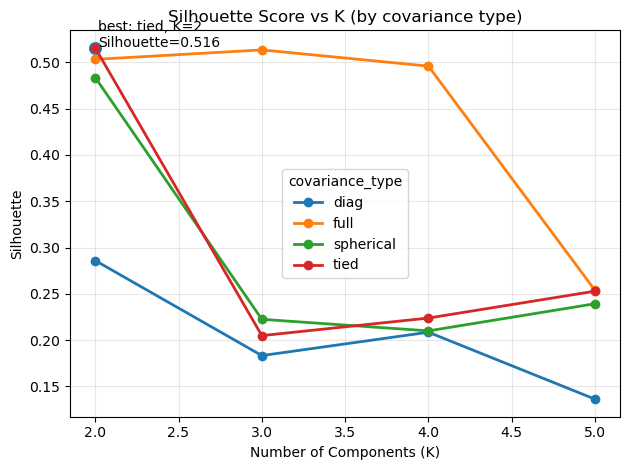

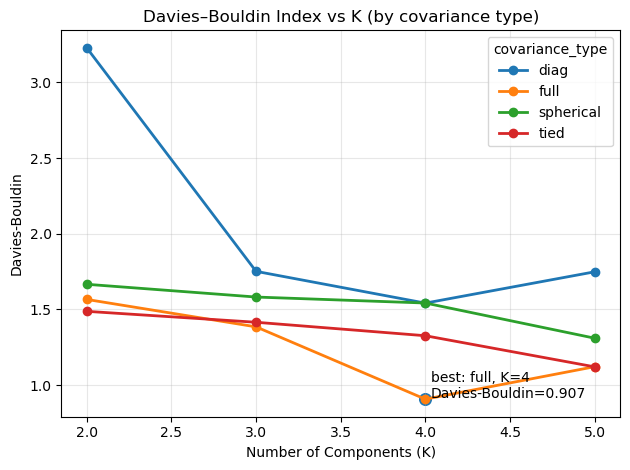

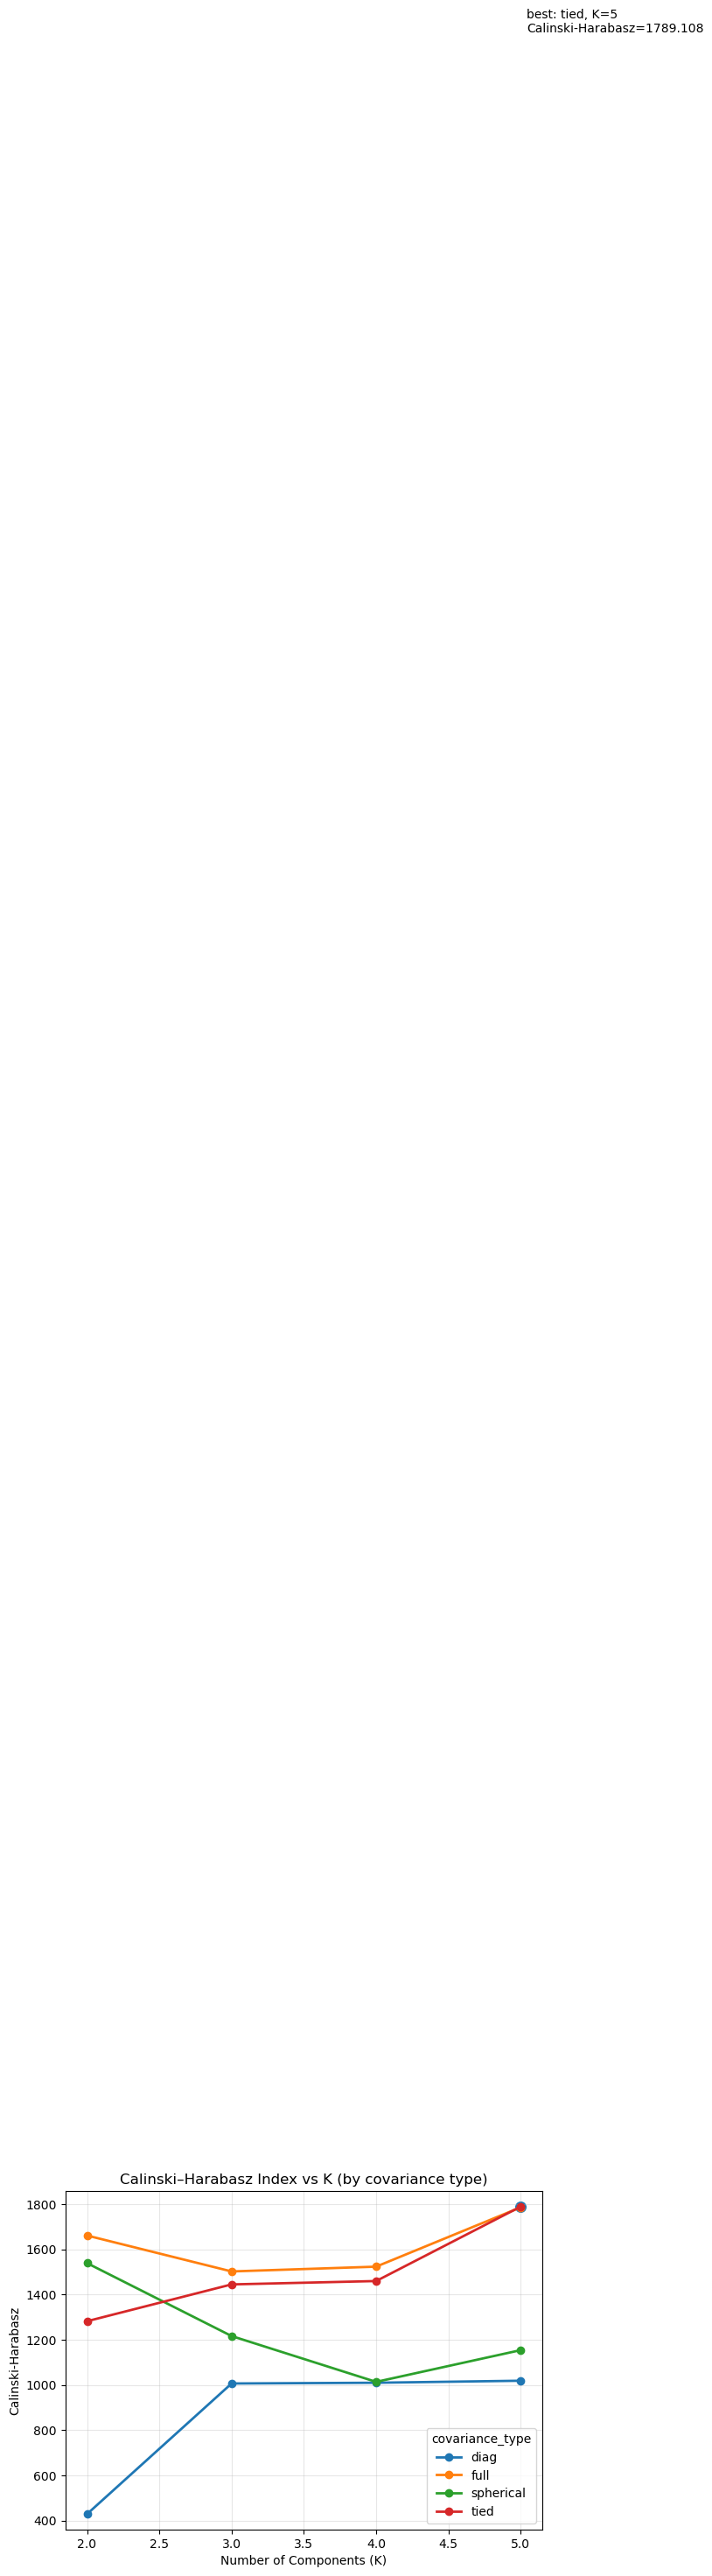

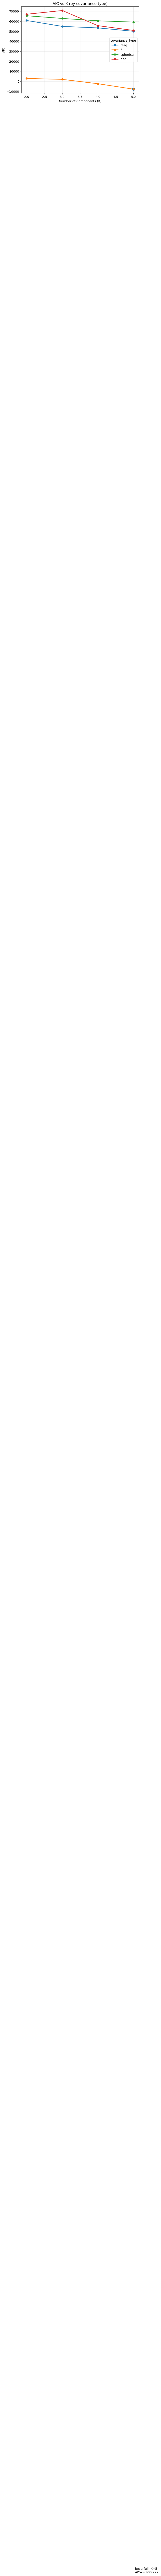

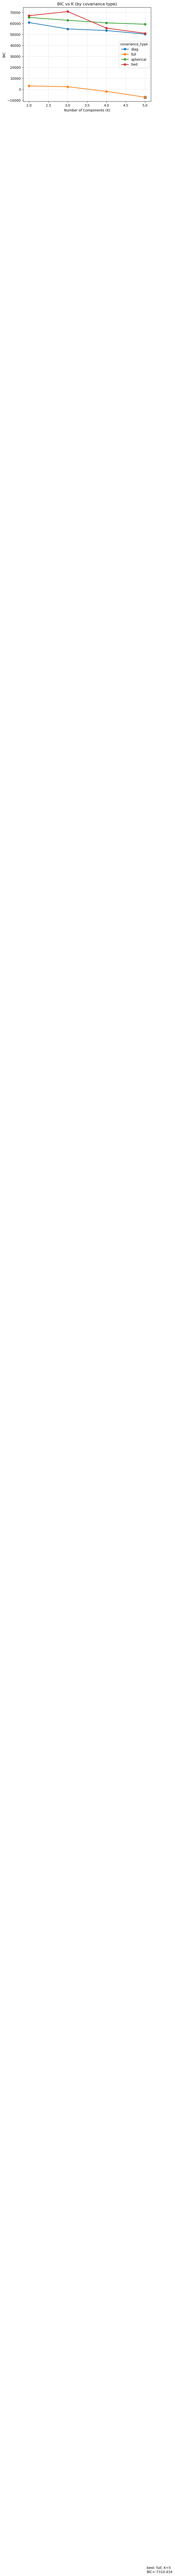

In [25]:
# Silhouette (higher is better)
plot_metric_lines(ablation, "Silhouette",
                  title="Silhouette Score vs K (by covariance type)",
                  best_is="max")

# Davies–Bouldin (lower is better)
plot_metric_lines(ablation, "Davies-Bouldin",
                  title="Davies–Bouldin Index vs K (by covariance type)",
                  best_is="min")

# Calinski–Harabasz (higher is better)
plot_metric_lines(ablation, "Calinski-Harabasz",
                  title="Calinski–Harabasz Index vs K (by covariance type)",
                  best_is="max")

# AIC (lower is better) — if by “GIC” you meant AIC, this is it
plot_metric_lines(ablation, "AIC",
                  title="AIC vs K (by covariance type)",
                  best_is="min")

# BIC (lower is better)
plot_metric_lines(ablation, "BIC",
                  title="BIC vs K (by covariance type)",
                  best_is="min")

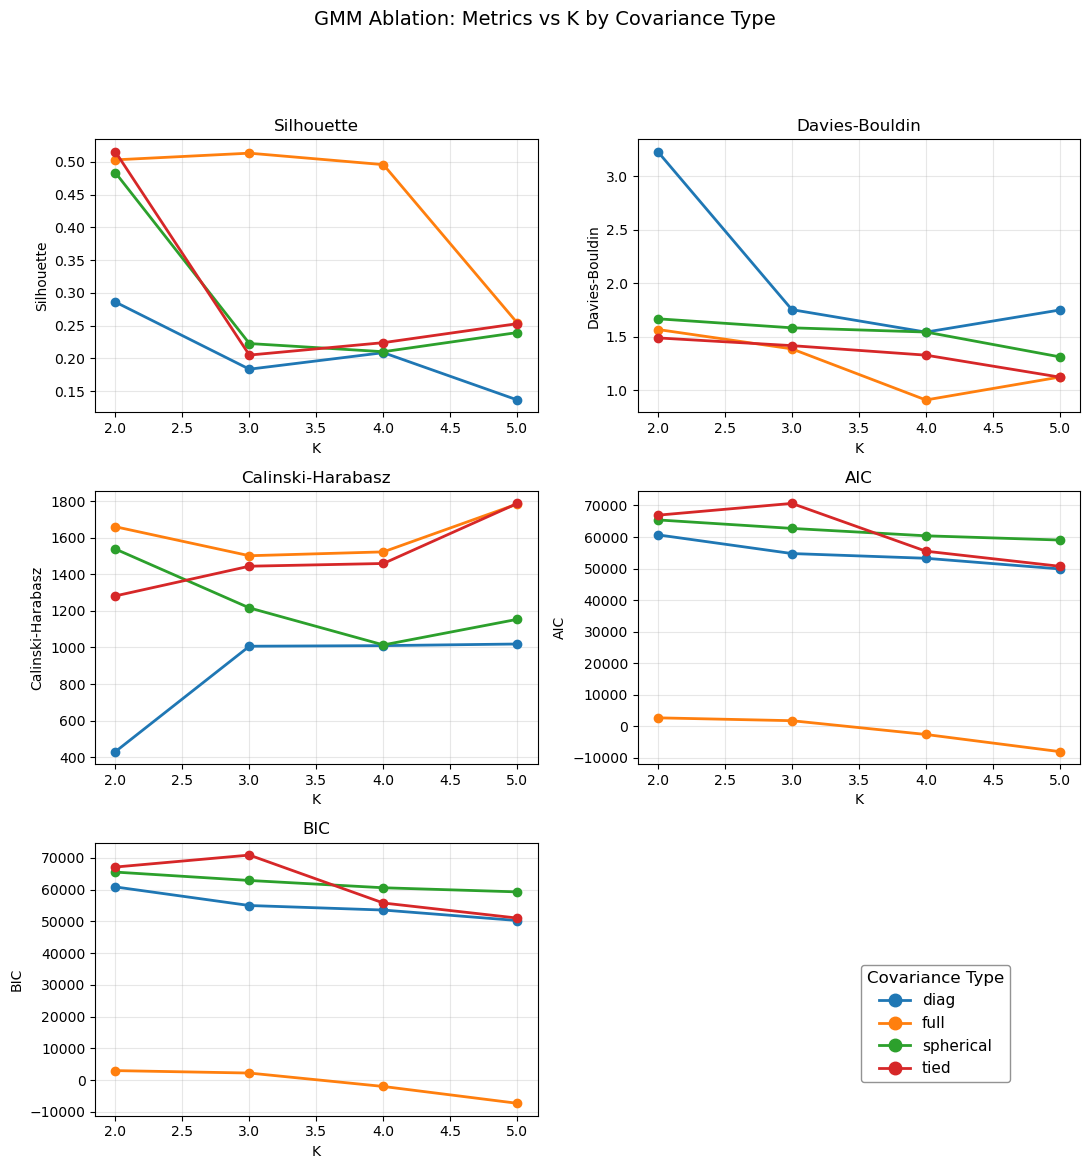

In [26]:
# JUPYTER CELL — Compact dashboard with adjusted legend placement

metrics = [
    ("Silhouette", "max"),
    ("Davies-Bouldin", "min"),
    ("Calinski-Harabasz", "max"),
    ("AIC", "min"),
    ("BIC", "min"),
]

fig, axes = plt.subplots(3, 2, figsize=(11, 12))
axes = axes.ravel()

for i, (metric, best_is) in enumerate(metrics):
    if i >= len(axes): break
    pivot = (ablation.pivot(index="n_components", columns="covariance_type", values=metric)
                     .sort_index())
    pivot.plot(ax=axes[i], marker="o", linewidth=2)
    axes[i].set_title(metric)
    axes[i].set_xlabel("K")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)

for ax in axes[:-1]:
    ax.legend_.remove()

# Hide the unused subplot (bottom-right)
if len(metrics) < len(axes):
    axes[-1].axis("off")

# --- One shared legend (bigger + closer to plots) ---
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(
    handles, labels,
    title="Covariance Type",
    loc="lower right",
    bbox_to_anchor=(0.93, 0.12),   # move slightly inward (↑ closer, ← left)
    frameon=True,
    ncol=1,
    fontsize=11,
    title_fontsize=12,
    markerscale=1.5                # make markers larger
)

# Transparent light box for better blending
legend.get_frame().set_alpha(0.85)
legend.get_frame().set_edgecolor("gray")

plt.suptitle("GMM Ablation: Metrics vs K by Covariance Type", y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


# World Bank

In [27]:
# JUPYTER CELL 2 — Load & preprocess
DATA_PATH = Path("world_bank_dataset.csv")  # change path if needed
df = pd.read_csv(DATA_PATH)

# numeric-only (GMM needs numeric)
X = df.select_dtypes(include=[np.number]).copy()
# drop constants if any
X = X.loc[:, X.nunique(dropna=False) > 1]

# impute + scale
pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
Xs = pre.fit_transform(X)

print("Shape after preprocessing:", Xs.shape)

Shape after preprocessing: (200, 7)


In [28]:
# JUPYTER CELL 3 — PCA
# Use a small PCA subspace for modeling; you can tune this
PCA_DIM = min(5, Xs.shape[1])
pca = PCA(n_components=PCA_DIM, random_state=42)
Xp = pca.fit_transform(Xs)

print("Explained variance ratio (first PCs):", pca.explained_variance_ratio_)

Explained variance ratio (first PCs): [0.17119597 0.16575291 0.16008311 0.14023969 0.13103084]


In [29]:
# numeric-only
X = df.select_dtypes(include=[np.number])
X = X.loc[:, X.nunique(dropna=False) > 1]  # drop constant cols

# Impute + Scale
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
Xs = pipe.fit_transform(X)

In [30]:
# PCA (for stability)
pca_dim = min(5, Xs.shape[1])
Xp = PCA(n_components=pca_dim, random_state=42).fit_transform(Xs)

In [31]:
# Optional sample
rng = np.random.default_rng(42)
idx = rng.choice(len(Xp), size=min(8000, len(Xp)), replace=False)
Xp_s = Xp[idx]

In [32]:
# GMM Ablation Study
# ---------------------
def run_gmm_ablation(X, k_list=(2,3,4,5,6), cov_types=("full","tied","diag","spherical")):
    results = []
    for k in k_list:
        for cov in cov_types:
            try:
                gm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
                gm.fit(X)
                labels = gm.predict(X)
                results.append({
                    "n_components": k,
                    "covariance_type": cov,
                    "Silhouette": silhouette_score(X, labels),
                    "Calinski-Harabasz": calinski_harabasz_score(X, labels),
                    "Davies-Bouldin": davies_bouldin_score(X, labels),
                    "AIC": gm.aic(X),
                    "BIC": gm.bic(X)
                })
            except Exception as e:
                results.append({"n_components": k, "covariance_type": cov, "Error": str(e)})
    return pd.DataFrame(results)

ablation = run_gmm_ablation(Xp_s)
ablation

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

,n_components,covariance_type,Silhouette,Calinski-Harabasz,Davies-Bouldin,AIC,BIC
0,2,full,0.128489,29.753444,2.496823,2952.679030,3087.910042
1,2,tied,0.143847,34.959061,2.235381,2942.852692,3028.608944
2,2,diag,0.111914,25.045509,2.722390,2939.551949,3008.816614
3,2,spherical,0.137205,32.864787,2.345620,2936.381601,2979.259727
4,3,full,0.135653,31.854047,2.102624,2941.152532,3145.648209
5,3,tied,0.160171,36.913007,1.832835,2937.007376,3042.553531
6,3,diag,0.151009,34.817391,1.895756,2955.748007,3061.294163
7,3,spherical,0.159097,37.039484,1.835579,2942.839954,3008.806301
8,4,full,0.132640,29.568020,1.826936,2948.930212,3222.690554
9,4,tied,0.126658,28.505916,1.927303,2914.005752,3039.341812


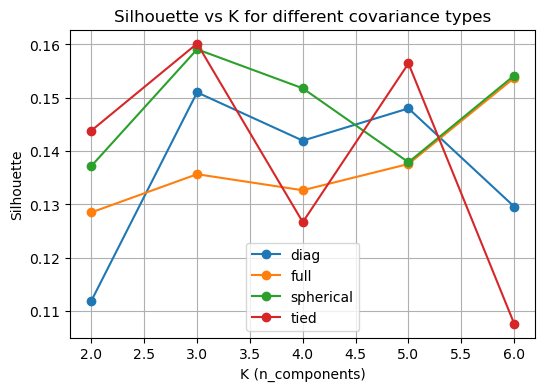

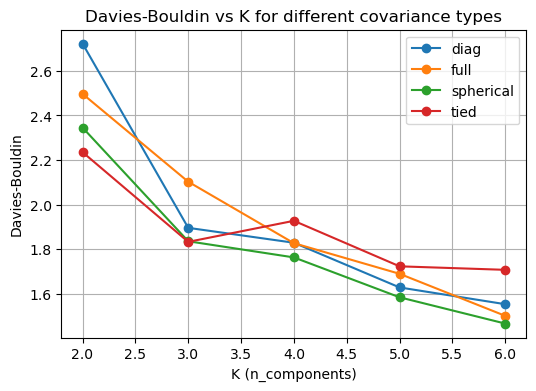

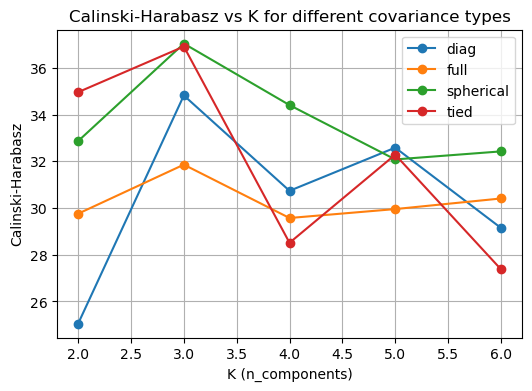

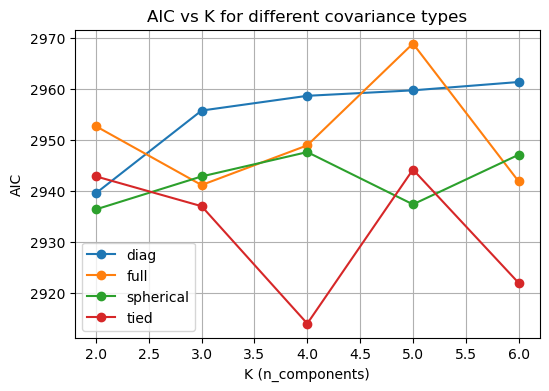

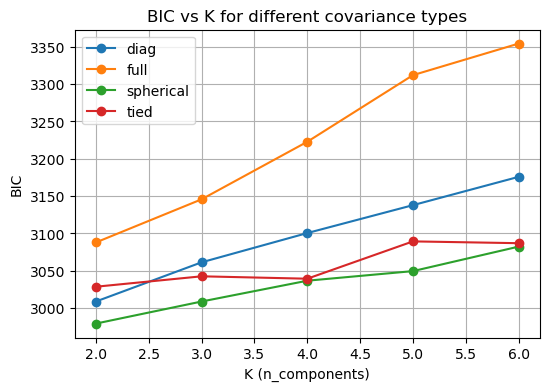

In [33]:
def plot_metric(df, metric):
    pivot = df.pivot(index="n_components", columns="covariance_type", values=metric)
    plt.figure(figsize=(6,4))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=col)
    plt.xlabel("K (n_components)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs K for different covariance types")
    plt.legend()
    plt.grid(True)
    plt.show()

for metric in ["Silhouette", "Davies-Bouldin", "Calinski-Harabasz", "AIC", "BIC"]:
    plot_metric(ablation, metric)


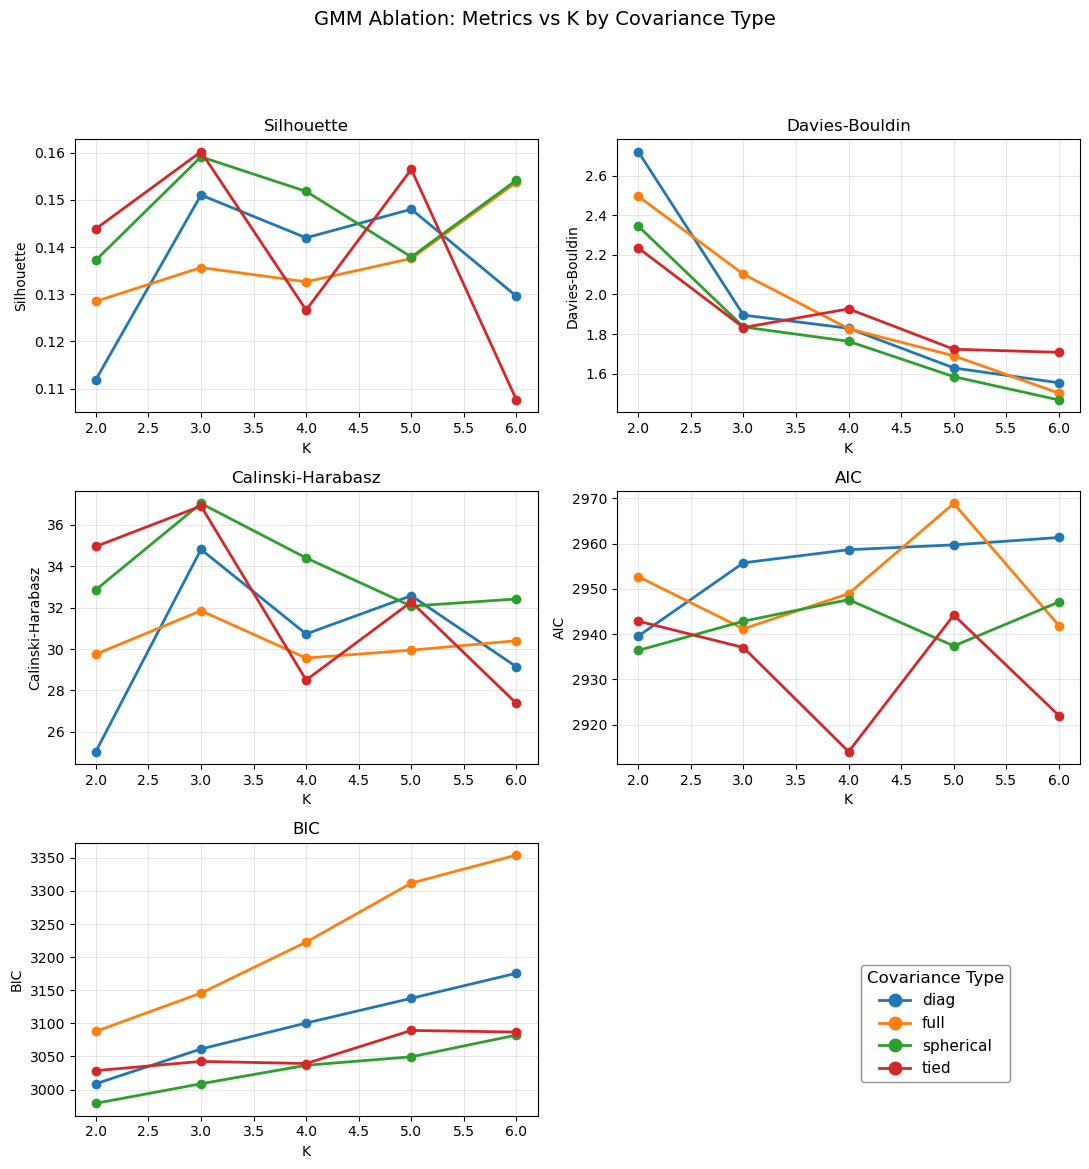

In [34]:
# JUPYTER CELL — Compact dashboard with adjusted legend placement

metrics = [
    ("Silhouette", "max"),
    ("Davies-Bouldin", "min"),
    ("Calinski-Harabasz", "max"),
    ("AIC", "min"),
    ("BIC", "min"),
]

fig, axes = plt.subplots(3, 2, figsize=(11, 12))
axes = axes.ravel()

for i, (metric, best_is) in enumerate(metrics):
    if i >= len(axes): break
    pivot = (ablation.pivot(index="n_components", columns="covariance_type", values=metric)
                     .sort_index())
    pivot.plot(ax=axes[i], marker="o", linewidth=2)
    axes[i].set_title(metric)
    axes[i].set_xlabel("K")
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)

for ax in axes[:-1]:
    ax.legend_.remove()

# Hide the unused subplot (bottom-right)
if len(metrics) < len(axes):
    axes[-1].axis("off")

# --- One shared legend (bigger + closer to plots) ---
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(
    handles, labels,
    title="Covariance Type",
    loc="lower right",
    bbox_to_anchor=(0.93, 0.12),   # move slightly inward (↑ closer, ← left)
    frameon=True,
    ncol=1,
    fontsize=11,
    title_fontsize=12,
    markerscale=1.5                # make markers larger
)

# Transparent light box for better blending
legend.get_frame().set_alpha(0.85)
legend.get_frame().set_edgecolor("gray")

plt.suptitle("GMM Ablation: Metrics vs K by Covariance Type", y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

Best model: n_components                   2
covariance_type        spherical
Silhouette              0.137205
Calinski-Harabasz      32.864787
Davies-Bouldin           2.34562
AIC                  2936.381601
BIC                  2979.259727
Name: 3, dtype: object


C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


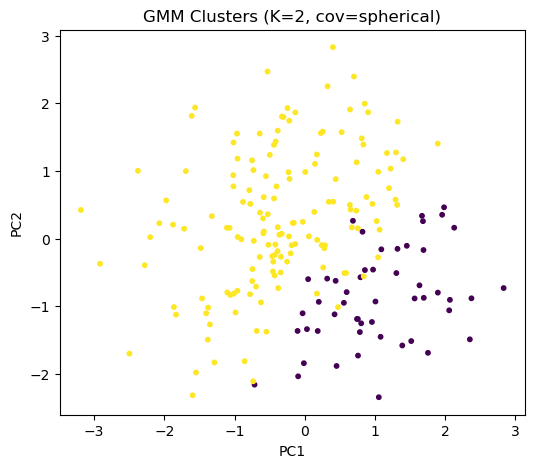

In [35]:
best = ablation.loc[ablation["BIC"].idxmin()]
print("Best model:", best)

best_gmm = GaussianMixture(
    n_components=int(best["n_components"]),
    covariance_type=best["covariance_type"],
    random_state=42
).fit(Xp)
labels = best_gmm.predict(Xp)

plt.figure(figsize=(6,5))
plt.scatter(Xp[:,0], Xp[:,1], c=labels, s=10, cmap="viridis")
plt.title(f"GMM Clusters (K={int(best['n_components'])}, cov={best['covariance_type']})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# GMM vs K-Means Clustering 

In [36]:
from sklearn.cluster import KMeans

In [37]:
# ==== Cell 2: Config ====
DATASETS = {
    "World Bank": "world_bank_dataset.csv",
    "Diabetes":   "diabetes_prediction_dataset.csv",
}

# Speed/quality knobs (tweak if you like)
PCA_DIM = 5
K_LIST_KMEANS = (2,3,4,5)              # range for K-Means
K_LIST_GMM    = (2,3,4,5)              # range for GMM
COV_TYPES_GMM = ("full","diag")        # keep 'tied','spherical' if you want slower but broader search
SIL_SAMPLE    = 8000                   # sample for silhouette (O(n^2)); lower for faster
BIC_SAMPLE    = 6000                   # sample for GMM model selection; lower for faster
RANDOM_STATE  = 42

# K-Means RANDOM init (purely random centroids) + several restarts
KMEANS_INIT    = "random"
KMEANS_N_INIT  = 20                # multiple random restarts; still random init
KMEANS_ALGO    = "lloyd"           # explicit algorithm

def load_preprocess(path, pca_dim=PCA_DIM):
    df = pd.read_csv(path)
    X = df.select_dtypes(include=[np.number]).copy()
    X = X.loc[:, X.nunique(dropna=False) > 1]
    pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler",  StandardScaler())])
    Xs = pipe.fit_transform(X)
    pca_dim = min(pca_dim, Xs.shape[1])
    Z = PCA(n_components=pca_dim, random_state=RANDOM_STATE).fit_transform(Xs)
    return Z

def eval_metrics(Z, labels, sil_sample=SIL_SAMPLE):
    n = len(Z)
    s  = silhouette_score(Z, labels, sample_size=min(sil_sample, n), random_state=RANDOM_STATE)
    db = davies_bouldin_score(Z, labels)
    ch = calinski_harabasz_score(Z, labels)
    return s, db, ch

In [38]:
def run_kmeans_random_best(Z, k_list=K_LIST_KMEANS):
    best = {"score": -1, "model": None}
    for k in k_list:
        km = KMeans(
            n_clusters=k,
            init=KMEANS_INIT,        # <-- RANDOM centroids
            n_init=KMEANS_N_INIT,    # multiple random restarts
            algorithm=KMEANS_ALGO,
            random_state=RANDOM_STATE
        )
        labels = km.fit_predict(Z)
        s, _, _ = eval_metrics(Z, labels)
        if s > best["score"]:
            best = {"score": s, "model": km}
    return best["model"]
    
def run_kmeans_random_best(Z, k_list=K_LIST_KMEANS):
    best = {"score": -1, "model": None}
    for k in k_list:
        km = KMeans(
            n_clusters=k,
            init=KMEANS_INIT,        # <-- RANDOM centroids
            n_init=KMEANS_N_INIT,    # multiple random restarts
            algorithm=KMEANS_ALGO,
            random_state=RANDOM_STATE
        )
        labels = km.fit_predict(Z)
        s, _, _ = eval_metrics(Z, labels)
        if s > best["score"]:
            best = {"score": s, "model": km}
    return best["model"]

def run_gmm_best(Z, k_list=K_LIST_GMM, cov_types=COV_TYPES_GMM, bic_sample=BIC_SAMPLE):
    rng = np.random.default_rng(RANDOM_STATE)
    idx = rng.choice(len(Z), size=min(bic_sample, len(Z)), replace=False)
    Zs = Z[idx]

    best = None
    for k in k_list:
        for cov in cov_types:
            gm = GaussianMixture(n_components=k, covariance_type=cov,
                                 max_iter=300, n_init=2, reg_covar=1e-6,
                                 random_state=RANDOM_STATE).fit(Zs)
            bic = gm.bic(Zs)
            if (best is None) or (bic < best["bic"]):
                best = {"k": k, "cov": cov, "bic": bic}

    gm_full = GaussianMixture(n_components=best["k"], covariance_type=best["cov"],
                              max_iter=400, n_init=3, reg_covar=1e-6,
                              random_state=RANDOM_STATE).fit(Z)
    labels = gm_full.predict(Z)
    s, db, ch = eval_metrics(Z, labels)
    return gm_full, best, s, db, ch

In [39]:
records = []
for ds_name, csv_path in DATASETS.items():
    Z = load_preprocess(csv_path, PCA_DIM)

    # K-Means (RANDOM init)
    km = run_kmeans_random_best(Z)
    s_km, db_km, ch_km = eval_metrics(Z, km.labels_)
    records.append({
        "dataset": ds_name, "method": "K-Means",
        "k": km.n_clusters, "covariance": None,
        "silhouette": s_km, "davies_bouldin": db_km, "calinski_harabasz": ch_km
    })

    # GMM
    gmm, gsel, s_gm, db_gm, ch_gm = run_gmm_best(Z)
    records.append({
        "dataset": ds_name, "method": f"GMM ({gsel['cov']})",
        "k": gsel["k"], "covariance": gsel["cov"],
        "silhouette": s_gm, "davies_bouldin": db_gm, "calinski_harabasz": ch_gm
    })

results = pd.DataFrame(records)
display(results.round(4))

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

,dataset,method,k,covariance,silhouette,davies_bouldin,calinski_harabasz
0,World Bank,K-Means,5,None,0.1773,1.4745,36.0960
1,World Bank,GMM (diag),2,diag,0.1242,2.3354,29.2923
2,Diabetes,K-Means,3,None,0.5076,1.2453,31472.0101
3,Diabetes,GMM (full),5,full,0.2521,1.1042,35676.2635


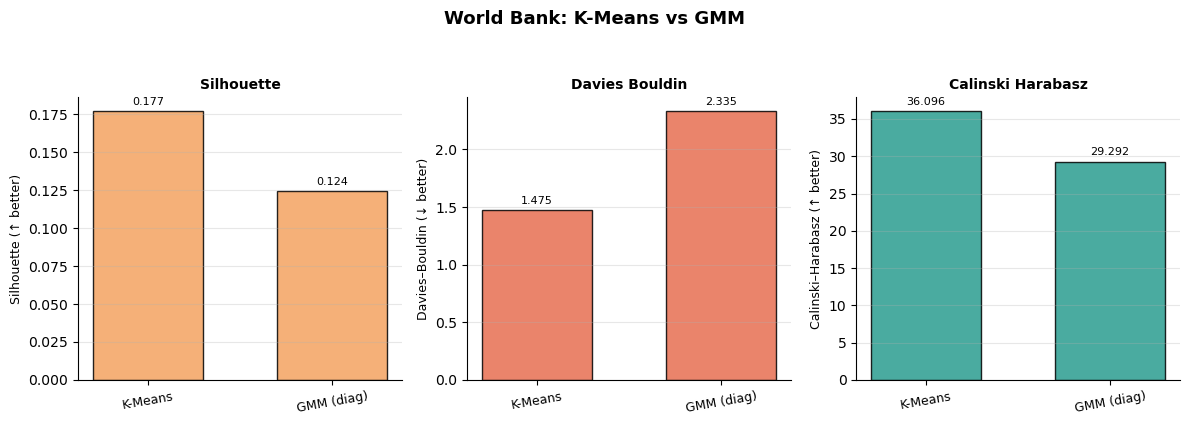

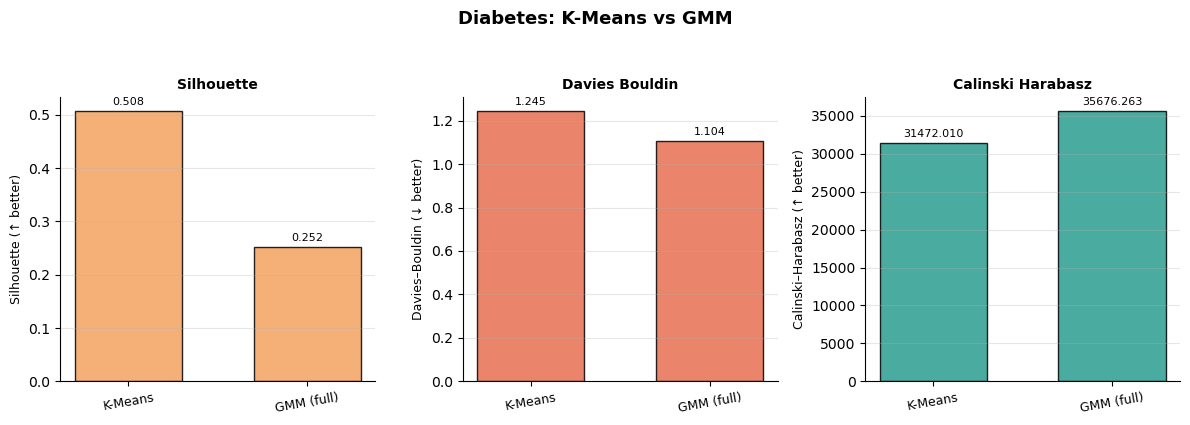

In [41]:
# ==== Cell 5: Bar charts ====
def plot_dataset_bars_by_metric_color(df_ds, title_prefix, save_path=None):
    metric_colors = {
        "silhouette": "#F4A261",       # orange
        "davies_bouldin": "#E76F51",   # coral red
        "calinski_harabasz": "#2A9D8F" # teal
    }
    labels = df_ds["method"].tolist()
    x = np.arange(len(labels))
    width = 0.6
    metrics = [
        ("silhouette", "Silhouette (↑ better)"),
        ("davies_bouldin", "Davies–Bouldin (↓ better)"),
        ("calinski_harabasz", "Calinski–Harabasz (↑ better)")
    ]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, (col, ylab) in zip(axes, metrics):
        vals = df_ds[col].values
        bars = ax.bar(x, vals, width, color=metric_colors[col], edgecolor="black", alpha=0.85)
        ax.set_xticks(x); ax.set_xticklabels(labels, rotation=10, fontsize=9)
        ax.set_ylabel(ylab, fontsize=9)
        ax.set_title(col.replace("_"," ").title(), fontsize=10, fontweight="bold")
        for b in bars:
            ax.annotate(f"{b.get_height():.3f}",
                        xy=(b.get_x()+b.get_width()/2, b.get_height()),
                        xytext=(0,3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)
        ax.grid(True, axis="y", alpha=0.3)
        ax.spines[['top','right']].set_visible(False)
    fig.suptitle(f"{title_prefix}: K-Means vs GMM", y=1.05, fontsize=13, fontweight="bold")
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# One figure per dataset
for ds in results["dataset"].unique():
    plot_dataset_bars_by_metric_color(
        results[results["dataset"] == ds],
        ds,
        save_path=f"compare_kmeans_gmm_{ds.lower().replace(' ', '_')}.png"
    )